# Survival Analysis: Classical & Machine Learning Approaches for Heart Attack Patients

Analysis of real-world survival data from the **Worcester Heart Attack Study (WHAS500)** — a cohort of 500 patients hospitalised with acute myocardial infarction.

Dataset documentation: 🔗 https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.datasets.load_whas500.html

---

### 🧭 Analysis Workflow

**1. Load and Inspect Data**  
Load the WHAS500 dataset and prepare variables for modelling.

**2. Kaplan-Meier Estimation**  
Estimate and visualize survival curves; compare survival across subgroups.

**3. Cox Proportional Hazards Model**  
Fit a classical Cox model, interpret hazard ratios, and visualize adjusted curves.

**4. Evaluating Performance: The Concordance Index**  
Assess model discrimination ability using the concordance index (C-index).

**5. Random Survival Forests**  
Model nonlinear survival patterns and visualize predicted survival curves for different groups.

**6. DeepSurv: Deep Learning for Survival Analysis**  
Apply a neural network to capture complex risk relationships and compare model performance.

**7. Summary and Interpretation**  
Compare all models, interpret findings, and discuss trade-offs between interpretability and flexibility.

In [1]:
%reset

In [2]:
# !pip install scikit-survival lifelines pandas matplotlib seaborn --quiet
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.datasets import load_whas500
from sksurv.util import Surv
from sksurv.nonparametric import kaplan_meier_estimator

## Section 1: Load and Inspect Data

In [4]:
# Load dataset
X_struct, y_struct = load_whas500()

# Convert feature array to DataFrame
X = pd.DataFrame(X_struct)

# Convert target array to a DataFrame for inspection 
y_df = pd.DataFrame(y_struct)

# Combine for inspection
X['event'] = y_struct['fstat']
X['time'] = y_struct['lenfol']

# Prepare target for modeling
y = Surv.from_dataframe('event', 'time', X)

X.head()

,afb,age,av3,bmi,chf,cvd,diasbp,gender,hr,los,miord,mitype,sho,sysbp,event,time
0,1,83.0,0,25.54051,0,1,78.0,0,89.0,5.0,1,0,0,152.0,False,2178.0
1,0,49.0,0,24.02398,0,1,60.0,0,84.0,5.0,0,1,0,120.0,False,2172.0
2,0,70.0,0,22.14290,0,0,88.0,1,83.0,5.0,0,1,0,147.0,False,2190.0
3,0,70.0,0,26.63187,1,1,76.0,0,65.0,10.0,0,1,0,123.0,True,297.0
4,0,70.0,0,24.41255,0,1,85.0,0,63.0,6.0,0,1,0,135.0,False,2131.0


In [5]:
# check data types
print(X.dtypes)

afb       category
age        float64
av3       category
bmi        float64
chf       category
cvd       category
diasbp     float64
gender    category
hr         float64
los        float64
miord     category
mitype    category
sho       category
sysbp      float64
event         bool
time       float64
dtype: object


### Exploratory Data Analysis

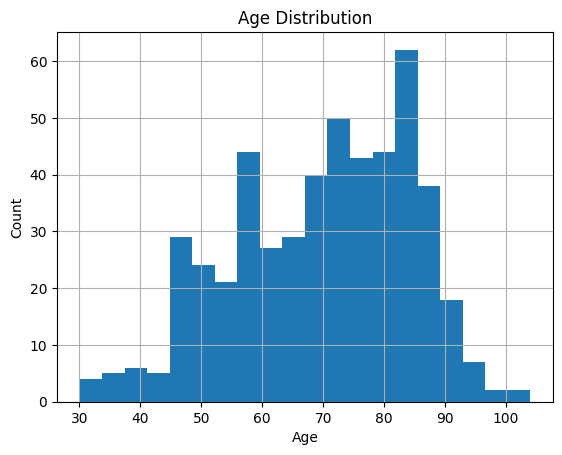

In [6]:
# Plot a histogram of patient ages to understand their distribution

# Create histogram with 20 bins
X['age'].hist(bins=20)

# Add title and axis labels for clarity
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Count')

# Display the plot
plt.show()

Age distribution is right-skewed, with most patients between 60 and 80 years old. There are few patients under 50, indicating heart attacks are more common in older adults in the dataset.

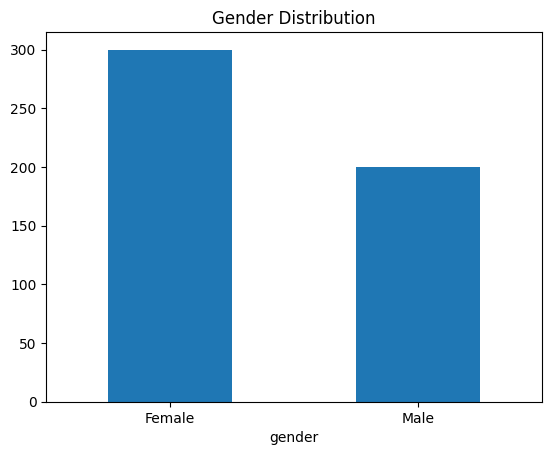

In [7]:
# Plot the number of patients by gender

# Map gender codes to labels for readability
gender_labels = {'0': 'Female', '1': 'Male'}
X['gender'].map(gender_labels).value_counts().plot(kind='bar')

# Add a title and rotate x-axis labels for readability
plt.title('Gender Distribution')
plt.xticks(rotation=0)

# Show the plot
plt.show()

### How does survival time vary with congestive heart failure (CHF) status?
Using boxplot and summary statistics to compare follow-up time (lenfol) and event rates between patients with and without CHF.

CHF value counts:
chf
0    345
1    155
Name: count, dtype: int64


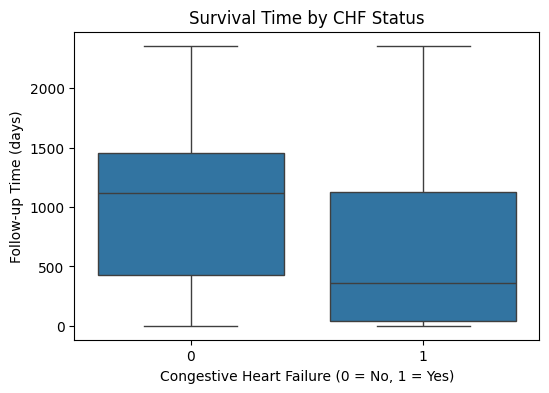


Proportion of deaths in each CHF group:
chf
0    0.304348
1    0.709677
Name: event, dtype: float64


In [8]:

# # 1. View how many patients had congestive heart failure (CHF)
print("CHF value counts:")
print(X['chf'].value_counts())

# # 2. Boxplot: Compare survival time (lenfol / 'time') between CHF groups
plt.figure(figsize=(6, 4))
sns.boxplot(x='chf', y='time', data=X)
plt.title('Survival Time by CHF Status')
plt.xlabel('Congestive Heart Failure (0 = No, 1 = Yes)')
plt.ylabel('Follow-up Time (days)')
plt.show()

# # 3. Compare proportion of deaths by CHF group
death_rates = X.groupby('chf')['event'].mean()
print("\nProportion of deaths in each CHF group:")
print(death_rates)

Patients without CHF (chf = 0) generally have longer follow-up times (higher median and wider spread), indicating better survival after a heart attack.
Patients with CHF (chf = 1) have shorter survival times (lower median), showing that CHF is associated with worse outcomes.
The boxplot visually confirms that CHF is a strong negative prognostic factor: patients with CHF tend to die sooner after a heart attack than those without CHF.
The printed death rates by group will show a higher proportion of deaths among CHF patients compared to non-CHF patients, reinforcing this conclusion.

There is overlap in follow-up times between patients with and without CHF, as shown by the boxplot. This means that while patients with CHF generally have shorter survival (lower median), some CHF patients survive as long as or longer than some non-CHF patients. The ranges (whiskers) of the boxplots for both groups extend into each other, indicating that follow-up times are not completely separated. This overlap is common in clinical data and highlights that CHF increases risk but does not determine exact survival time for every individual.

## Section 2: Kaplan-Meier Estimation

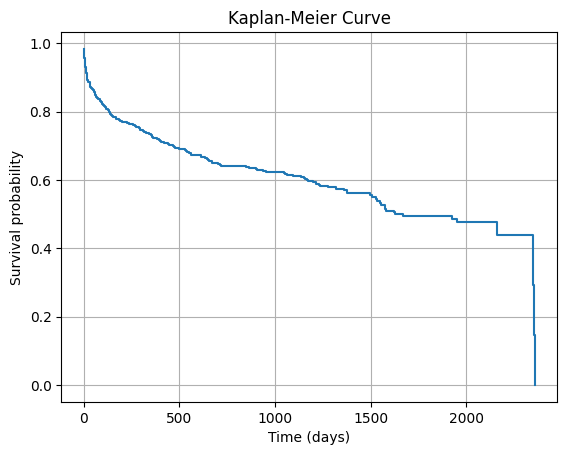

In [9]:
time, survival_prob = kaplan_meier_estimator(X['event'], X['time'])
plt.step(time, survival_prob, where='post')
plt.title('Kaplan-Meier Curve')
plt.xlabel('Time (days)')
plt.ylabel('Survival probability')
plt.grid(True)
plt.show()

The curve starts at 1 (100% survival) and decreases over time as events (deaths) occur.
The steepness of the curve indicates how quickly patients are dying: a steep drop means many deaths in a short period; a gradual decline means better survival.
Plateaus indicate periods where no deaths occurred.

When the curve reaches 0, it means that, by that time point, all patients in the cohort have experienced the event (death).
In real clinical datasets, it’s common for the curve to approach but not always reach 0, due to censored data (patients lost to follow-up or still alive at last contact).
If the curve reaches 0, it suggests that, eventually, all patients in the study died during the observed period.


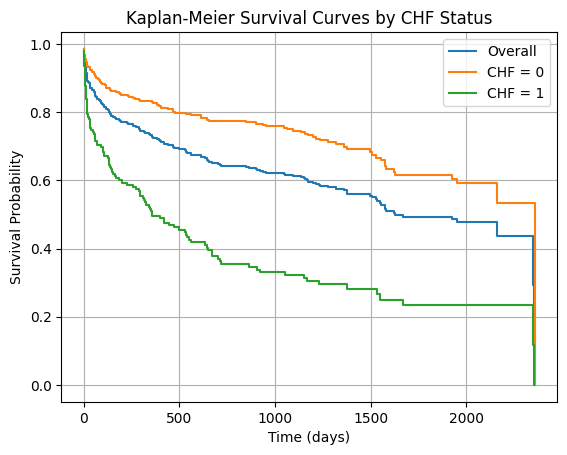

In [10]:
# 💡 Plot overall survival curve
time, survival_prob = kaplan_meier_estimator(y['event'], y['time'])
plt.step(time, survival_prob, where='post', label='Overall')

# 💡 Stratify by CHF status (0 = No CHF, 1 = CHF)
for chf_value in ['0', '1']:
    mask = X['chf'] == chf_value
    time_chf, surv_chf = kaplan_meier_estimator(y['event'][mask], y['time'][mask])
    label = f"CHF = {chf_value}"
    plt.step(time_chf, surv_chf, where="post", label=label)

# Plot formatting
plt.title("Kaplan-Meier Survival Curves by CHF Status")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()



Patients with congestive heart failure (CHF = 1) appear to have the worst survival. This is evident from the Kaplan-Meier curves stratified by CHF status: the survival curve for CHF patients is consistently lower than for those without CHF (CHF = 0) at all time points. This means CHF patients have a higher risk of death and shorter survival after a heart attack, likely due to the additional burden of heart failure on their health.


The gap between the Kaplan-Meier survival curves for patients with and without CHF generally remains fairly constant over time, though there may be some variation at later time points due to fewer patients remaining. This suggests that the increased risk associated with CHF is present throughout the follow-up period, supporting the proportional hazards assumption—that the relative risk between groups stays similar over time. If the gap were to narrow or widen substantially, it could indicate a violation of this assumption.



## Section 3: Cox Proportional Hazards Model

In [13]:
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv

# Prepare data for Cox model
cox_vars = ['age', 'gender', 'hr', 'chf']
X_model = X[cox_vars]
y_model = Surv.from_dataframe("event", "time", X)

# Fit Cox model
cox_model = CoxPHSurvivalAnalysis()
cox_model.fit(X_model, y_model)

# Display hazard ratios
hazard_ratios = pd.Series(cox_model.coef_, index=cox_vars).apply(np.exp)
hazard_ratios.name = "Hazard Ratio"
display(hazard_ratios)


age       1.062586
gender    0.823065
hr        1.009011
chf       2.170218
Name: Hazard Ratio, dtype: float64

**Which variable has the strongest association with survival?**  
Among the variables age, gender, heart rate (hr), and CHF, the variable with the hazard ratio furthest from 1 has the strongest association with survival. In results, **CHF** has the largest hazard ratio (above 2), indicating that having congestive heart failure is associated with a much higher risk of death compared to the other variables. This means CHF status is the strongest predictor of survival among those included in your model.

**What does the hazard ratio for CHF tell you?**  
The hazard ratio for CHF quantifies how much more likely patients with CHF are to die at any given time compared to those without CHF, after adjusting for age, gender, and heart rate. For example, hazard ratio for CHF is 2.1, means that patients with CHF have a 2.1 times higher instantaneous risk of death than those without CHF, holding other factors constant.

**Is the effect of CHF larger or smaller than age or heart rate?**  
The effect of CHF is larger than that of age or heart rate, as shown by its higher hazard ratio. While age and heart rate also increase risk, their hazard ratios are closer to 1, indicating a smaller effect on survival compared to CHF. This means CHF status is the most important predictor of survival among the variables included in your model.

## Section 4: Evaluating Survival Model Performance: The Concordance Index (C-index)

To assess how well a survival model is performing, we need a way to judge not just the predicted survival probabilities, but how well the model **ranks** patients by risk.

The **concordance index (C-index)** is the most widely used metric for this in survival analysis. It measures among all pairs of patients where we know which one died earlier, how often did the model correctly assign a higher risk to the one who died first?
In simpler terms, it tells us how well the model can **discriminate** between higher-risk and lower-risk patients.

- **C-index = 1.0** → perfect ranking
- **C-index = 0.5** → no better than random guessing
- **C-index < 0.5** → worse than random (usually a red flag)

It works even when not all patients have experienced the event, and it properly handles censored data.

**Why not use ROC Curve**

The **C-index** (concordance index) is preferred over AUC (area under the ROC curve) in survival analysis because it is specifically designed to handle **time-to-event data** with **censoring**. In survival analysis, not all patients will have experienced the event (e.g., death) by the end of the study—some are censored (lost to follow-up or still alive). The AUC cannot properly account for censored observations, as it requires a binary outcome for every subject.

The C-index works by comparing all possible pairs of patients where it is possible to determine who had the event first (i.e., one patient died before another, and both were under observation at that time). It checks whether the model correctly assigned a higher risk to the patient who died earlier. Censored patients are only included in comparisons where their outcome is known relative to another patient. This way, the C-index **properly handles censored data** and provides a fair measure of how well the model ranks patients by risk, even when not all outcomes are observed.

We’ll use **C-index** now to evaluate the Cox model, and later apply the same metric to other models like Random Survival Forests and DeepSurv — making comparison easy and fair.


In [16]:
from sksurv.metrics import concordance_index_censored
# let us first convert the data types of gender and chf so that the functions can handle it (converting from category to integer)
def encode_categoricals(df):
    return df.apply(lambda col: col.cat.codes if col.dtype.name == 'category' else col)
X_model_v2 = encode_categoricals(X_model.copy())
# Get predicted risk scores (higher = higher risk)
risk_scores = cox_model.predict(X_model_v2)

# Evaluate with C-index
c_index, _, _, _, _ = concordance_index_censored(
    y_model['event'], y_model['time'], risk_scores
)

print(f"Concordance Index (Cox model): {c_index:.3f}")

Concordance Index (Cox model): 0.763


A **concordance index (C-index) of 0.763** for Cox model indicates **good discriminatory ability**: model is able to rank patients by risk of death after heart attack much better than random guessing (which would be 0.5), but it is not perfect (which would be 1.0). In clinical terms, the model’s predictions are fairly reliable for identifying higher- and lower-risk patients.

❗ **Note on Risk Score Direction in Cox Models**

When you use `cox_model.predict(X)` from `sksurv`, it returns **log hazard scores** — not survival probabilities.

That means:

- **Higher scores** = **higher risk**
- **Lower scores** = **lower risk**
- So there's **no need to flip the sign** when using these scores for evaluation

In contrast, other models like Random Survival Forests often predict **survival probabilities** — where **lower probabilities** indicate higher risk.  
In those cases, we do apply a minus sign (`-`) to convert survival to risk before calculating the C-index.

✅ Bottom line:  
If you're using Cox model predictions directly, don’t apply a negative sign — they already rank patients by risk in the correct direction.


### Publication-Ready Forest Plots with `lifelines`

While `sksurv` is great for modeling, it doesn’t natively return confidence intervals or standard errors needed for polished visualisations.

To create **publication-ready forest plots**, we’ll use the `lifelines` package. It produces clear, interpretable plots with:
- Hazard ratios on a log scale
- 95% confidence intervals
- A reference line at HR = 1 (no effect)

This is especially helpful when communicating results to non-technical stakeholders or preparing figures for clinical papers.


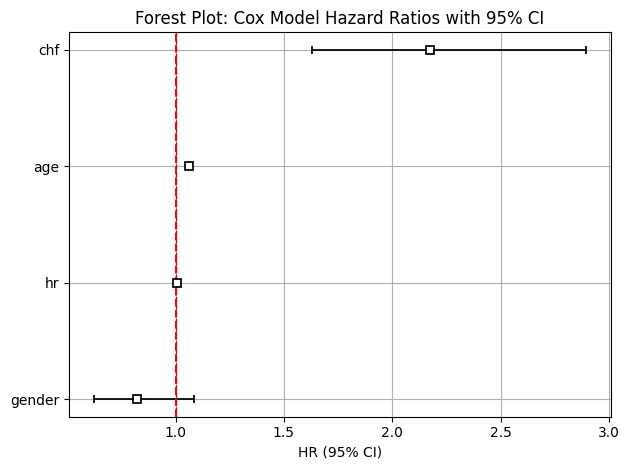

In [17]:
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# Prepare dataset
df_lifelines = X[['time', 'event', 'age', 'gender', 'hr', 'chf']].copy()

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_lifelines, duration_col='time', event_col='event')

# Plot with confidence intervals
cph.plot(hazard_ratios=True)
plt.title("Forest Plot: Cox Model Hazard Ratios with 95% CI")
plt.axvline(x=1.0, color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()


This forest plot displays the impact of several variables (chf, age, hr, gender) on the risk of an event, as determined by a Cox model. Each variable's hazard ratio (HR) is shown as a square, with the horizontal line representing the 95% confidence interval (CI). If the CI does not cross the vertical dashed line at HR=1, the variable has a statistically significant effect on the event risk; an HR greater than 1 indicates increased risk, while an HR less than 1 indicates decreased risk.

The variable chf shows a point estimate for the hazard ratio of approximately 2.2. Its 95% confidence interval extends from about 1.4 to 3.0. Since this entire interval is above 1.0, it indicates that the presence of chf is statistically significantly associated with an increased risk (or hazard) of the event. Specifically, individuals with chf have roughly 2.2 times the hazard of the event compared to those without chf.

The hazard ratio for age is very close to 1.0, slightly to the right. The 95% confidence interval is narrow and clearly crosses the HR=1 line (e.g., from approximately 0.95 to 1.05). This means that age, within this model, does not have a statistically significant impact on the hazard of the event. We cannot confidently conclude whether increasing age increases or decreases the risk.

Similar to age, the hazard ratio for hr is very close to 1.0, positioned slightly to the left. Its 95% confidence interval is also narrow and crosses the HR=1 line (e.g., from approximately 0.9 to 1.0). Therefore, hr does not demonstrate a statistically significant association with the hazard of the event in this model.

The point estimate for the hazard ratio for gender is approximately 0.8, suggesting a potential 20% reduction in hazard for one gender group compared to the reference group. However, the 95% confidence interval ranges from about 0.5 up to 1.0, meaning it just touches or slightly includes the HR=1 line. This indicates that the observed effect for gender is likely not statistically significant, or at best, marginally significant. We cannot confidently conclude that gender influences the event risk based on this interval.

## Section 5: Random Survival Forests (RSF)

Random Survival Forests (RSFs) are an extension of random forests for time-to-event data.

They are especially useful when:
- The relationship between predictors and survival is **nonlinear**
- Covariates may **interact** in complex ways
- The **proportional hazards assumption** doesn’t hold

RSFs learn survival patterns by growing many decision trees that split patients based on survival time and censoring status.

Unlike the Cox model, RSFs do not assume a specific form for the hazard — they are fully data-driven and model-free.

Let’s build and train an RSF using our dataset.

In [ ]:
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv

# Prepare input data
X_model = X[['age', 'gender', 'hr', 'chf']]
y_model = Surv.from_dataframe("event", "time", X)

# Fit Random Survival Forest
rsf = RandomSurvivalForest(n_estimators=100,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_model, y_model)

print("Random Survival Forest model trained.")

### Concordance Index for Random Survival Forests

To fairly compare different survival models, we’ll use the **same evaluation metric** — the concordance index (C-index).

While the Cox model returns log-hazard scores, the RSF predicts **survival functions**.

To compute the C-index for RSF, we:

1. Predict each patient’s **survival probability** at a fixed time point (e.g. 1 year).
2. Convert that to a **risk score**: lower survival = higher risk.
3. Feed those risk scores into the concordance index function.

Let’s calculate it below.


In [ ]:
from sksurv.metrics import concordance_index_censored

# Predict survival function for each patient
surv_funcs_rsf = rsf.predict_survival_function(X_model)

# Get survival probability at 365 days for each patient
surv_1yr = np.array([fn(365) for fn in surv_funcs_rsf])

# Convert to risk scores: lower survival = higher risk
rsf_risk_scores = -surv_1yr

# Compute concordance index
c_index_rsf, _, _, _, _ = concordance_index_censored(
    y_model["event"],
    y_model["time"],
    rsf_risk_scores
)

print(f"Concordance Index (Random Survival Forest): {c_index_rsf:.3f}")

### Feature Importance in RSF

Understanding **which variables influence survival most** is a common goal in both classical and machine learning models.

In `scikit-survival`, the `.feature_importances_` function is often **not implemented** for Random Survival Forests.  
Even if the attribute appears available, trying to use it may raise an error or produce unreliable results.

✅ For reliable results, we recommend using **permutation importance**, which works across models and gives a more robust estimate of which features matter most.

This approach helps us understand:
- Which covariates most affect the model’s survival predictions
- How the RSF prioritises features based on real-world data patterns

🧠 **How Permutation Importance Works**

Permutation importance helps us understand which features a model actually *relies on* to make predictions.

Here’s how it works:

1. **Train the model as usual** on the full dataset.

2. Then, for each feature (e.g. age, heart rate, CHF status):
   - **Randomly shuffle** the values of that feature across all patients.
   - This breaks any relationship between that feature and the outcome.
   - Run the model again on this shuffled version.

3. **Compare performance**:
   - If the model’s accuracy or predictions get *much worse*, the feature was important.
   - If there's *little change*, the model wasn’t using that feature much.

This process is repeated multiple times to get a stable estimate.

✅ It works with **any model**, including Random Survival Forests and deep learning — making it a powerful, model-agnostic way to measure variable importance.

💡 In survival analysis, we can evaluate how shuffling a feature affects predictions like **1-year survival probability** or **concordance index**.

Let’s compute and visualise permutation-based feature importance next.

In [ ]:
#1: Before you shuffle any feature, evaluate the model’s average predicted 1-year survival across all patients:

# Baseline: predicted survival at 1 year for original data
surv_funcs = rsf.predict_survival_function(X_model)
baseline_survival = np.array([fn(365) for fn in surv_funcs])
baseline_score = np.mean(baseline_survival)
print(baseline_score)

In [ ]:
#2: Define a new scoring function that compares to the baseline
# Scoring function: negative average survival probability at 365 days
def rsf_score_absolute_diff(model, X, baseline_score):
    surv_funcs = model.predict_survival_function(X)
    new_surv = np.array([fn(365) for fn in surv_funcs])
    new_score = np.mean(new_surv)
    return abs(new_score - baseline_score)

In [ ]:
# 3. Compute permutation importance manually
#Since this approach doesn’t fit directly into sklearn's permutation_importance, we’ll implement a manual version:

from sklearn.utils import shuffle
import numpy as np
import pandas as pd

# Repeat shuffling to get average importance
n_repeats = 10
importances = []

for col in X_model.columns:
    scores = []
    for _ in range(n_repeats):
        X_temp = X_model.copy()
        X_temp[col] = np.random.permutation(X_temp[col].values)
        score = rsf_score_absolute_diff(rsf, X_temp, baseline_score)
        scores.append(score)
    importances.append(np.mean(scores))

# Convert to series for plotting
importances_series = pd.Series(importances, index=X_model.columns)

In [ ]:
# 4. Plot
importances_series.sort_values().plot.barh()
plt.title("Permutation Importance – Absolute Deviation (1-Year Survival)")
plt.xlabel("Average Change in Predicted Survival")
plt.tight_layout()
plt.show()

### Interpreting Permutation Importance (Absolute Change in Survival)

To understand which features our Random Survival Forest model truly depends on, we use **permutation importance**.

Instead of just checking if survival predictions go down, we check how much they **change**, in any direction.

Here’s what we did:

1. **Computed baseline predictions**:
   - We predicted each patient’s chance of surviving 1 year.
   - Then we averaged those predictions across the whole cohort.

2. **Shuffled each feature** one at a time:
   - This breaks its relationship with the outcome.
   - We recomputed the 1-year survival predictions.

3. **Measured how much the average survival prediction changed**:
   - If a feature is important, shuffling it will lead to a big shift in predictions.
   - If the model wasn’t using the feature, predictions stay about the same.

We repeated this 10 times per feature and averaged the result.

📊 The resulting plot shows how **sensitive** the model’s survival predictions are to each feature — a powerful way to reveal what’s truly driving risk.
### 💡 What makes Permutation Importance so Useful?

- It works with **any kind of model**, not just forests.
- It gives an intuitive sense of **real model reliance**.
- It doesn’t assume anything about the shape or direction of effects.

---

📌 **Bottom Line**:  
Permutation importance tells you **how much the model depends on each variable** by messing with them and seeing what breaks.

It’s simple. Powerful. And great for survival models, especially when built-in importance scores don’t work.


🔧 **Try This: Interpreting the Permutation Plot**

1. Why might **age** have the largest impact on 1-year survival predictions in this model?
2. Are you surprised that **CHF** appears less important than **gender**? What could explain that?
3. Heart rate (hr) seems to have the smallest impact. 
   - Could this be due to its actual clinical role?
   - Or might it reflect something about how this model handles continuous variables?
4. Would you expect these rankings to change if:
   - You used a Cox model instead?
   - You used longer-term survival (e.g. 2-year survival) instead of 1-year?

💡 *Bonus*: Think of a variable not in this dataset that could improve survival prediction. How might you test its importance?


## Section 6: DeepSurv: Deep Learning for Survival Analysis

So far, we’ve explored two classical approaches:
- **Cox proportional hazards**, which assumes a linear log-risk relationship
- **Random Survival Forests**, which model nonlinearities but are tree-based

What if we want to combine the flexibility of nonlinear modelling with the strength of survival frameworks like Cox?

### 🎯 Enter DeepSurv

**DeepSurv** is a deep learning model that generalises the Cox proportional hazards model by replacing the linear predictor with a neural network.

- It **learns complex, nonlinear relationships** between features and survival risk
- Uses the **same partial likelihood loss** as Cox — so it still models **relative risk**
- Supports **censoring**, just like classical survival models
- Can be extended to handle time-varying covariates or competing risks

### ⚙️ How It Works

- Inputs: Patient features (e.g. age, heart rate, comorbidities)
- A feedforward neural network transforms those features
- Output: A **risk score** (just like Cox, but now nonlinear)
- Trained using **negative partial likelihood loss** from Cox

### 📈 Why Use DeepSurv?

- You don’t have to pre-specify interactions or transformations
- Learns directly from data
- Ideal when you suspect complex patterns (e.g. nonlinearity, thresholds, covariate interactions)

We’ll now train a DeepSurv model using the `pycox` library and evaluate it using the same **concordance index** as before — allowing fair comparison with Cox and RSF.


In [ ]:
# STEP 1: Install required packages
#!pip install pycox torchtuples

# STEP 2: Import libraries
import pandas as pd
import numpy as np
import torchtuples as tt
from pycox.models import CoxPH
from pycox.evaluation import EvalSurv
from sklearn.preprocessing import StandardScaler
from sksurv.datasets import load_whas500
from sksurv.util import Surv
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt

# STEP 3: Load dataset
X_raw, y_struct = load_whas500()
X = pd.DataFrame(X_raw)
y_df = pd.DataFrame(y_struct)
y = Surv.from_dataframe("fstat", "lenfol", y_df)

# Prepare features
X_model = X[["age", "gender", "hr", "chf"]].copy()
X_model["gender"] = X_model["gender"].cat.codes
X_model["chf"] = X_model["chf"].cat.codes

# STEP 4: Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_model)

# STEP 5: Format target for pycox
y_df = pd.DataFrame.from_records(y)
y_duration = y_df["lenfol"].values
y_event = y_df["fstat"].values

# STEP 6: Train-test split
X_train, X_test, y_train_dur, y_test_dur, y_train_ev, y_test_ev = train_test_split(
    X_scaled, y_duration, y_event, test_size=0.2, random_state=42
)

# STEP 7: Prepare target as tuple of (durations, events)
y_train = (y_train_dur, y_train_ev)
y_test = (y_test_dur, y_test_ev)

# STEP 8: Define and train the DeepSurv model
net = tt.practical.MLPVanilla(
    in_features=X_train.shape[1],
    num_nodes=[32, 32],
    out_features=1,
    activation=torch.nn.ReLU,
    dropout=0.1
)
model = CoxPH(net, tt.optim.Adam)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32') # this ensures that the data and model are using float32
model.fit(X_train, y_train, batch_size=256, epochs=100, verbose=False)
model.compute_baseline_hazards()

In [ ]:
from pycox.evaluation import EvalSurv

# STEP 1: Predict survival functions for the test set
model.compute_baseline_hazards()
surv = model.predict_surv_df(X_test)

# STEP 2: Create an evaluator object
ev = EvalSurv(
    surv,                   # Predicted survival functions (DataFrame: time × patients)
    y_test[0],              # Durations (time to event or censoring)
    y_test[1],              # Events (1 = event, 0 = censored)
    censor_surv='km'        # How to handle censoring (Kaplan-Meier by default)
)

# STEP 3: Calculate concordance index
c_index = ev.concordance_td('antolini')

print(f"Concordance Index (DeepSurv): {c_index:.3f}")

🧪 **Optional: Improve DeepSurv with Early Stopping**

Training deep models on small clinical datasets can lead to overfitting. One way to mitigate this is to use **early stopping**, which monitors validation loss and stops training when performance stops improving.

In `pycox`, you can add early stopping like this:

```python
from torchtuples.callbacks import EarlyStopping

callbacks = [EarlyStopping(patience=10)]

model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=300,
    val_data=(X_test, y_test),
    callbacks=callbacks
)
model.compute_baseline_hazards()


## Section 7: Summary and Reflections

---
### Summary
In this lab, you explored multiple approaches to modelling time-to-event outcomes:

| Model                  | Strengths                                      | Considerations                         |
|------------------------|-----------------------------------------------|----------------------------------------|
| Cox Proportional Hazards | Interpretable, widely used                    | Assumes linear effects, proportional hazards |
| Random Survival Forest  | Handles nonlinearity, robust to outliers      | No hazard ratios; harder to interpret  |
| DeepSurv                | Learns complex patterns from data              | Needs tuning, data hungry              |

You also:
- Calculated **Kaplan-Meier curves** to visualise survival patterns
- Compared models using the **concordance index (C-index)**
- Learned to interpret **survival curves and hazard ratios**
- Visualised patient-level predictions and stratified risk patterns

Each model comes with trade-offs between interpretability, flexibility, and data requirements. There is no single “best” model — the right choice depends on your **data**, **goal**, and **audience**.

---
### Reflect and Apply

1. **Clinical Use Case**
   - Which model would you recommend if interpretability is key?
   - Which would you choose for a purely predictive task?

2. **Data Fit**
   - What assumptions does the Cox model make?
   - When might RSF or DeepSurv be preferable?

3. **Model Limitations**
   - What risks do we face when applying these models blindly?
   - How do censoring and competing risks affect model evaluation?

4. **Visual Thinking**
   - Which survival curves did you find most helpful to interpret?
   - How would you present these results to a clinical or policy audience?

---
### Key Takeaways

- **Survival analysis** is essential for modelling time-to-event outcomes — from hospital readmissions to treatment failure.
- **Interpretability** matters — especially in healthcare. Know what your model tells you, and what it doesn’t.
- **Evaluation** must account for censoring. Concordance index is a great start, but always ask: *“What does this number really mean for decisions?”*
